# Notebook to read or create a country mask and apply it to a 2D surface variable.

<div class="alert alert-success">


- This notebook assumes that the 2D variable to be converted is either already on the right grid, or that we know it's lat/lon values for the lower-left corners of each gridbox.
- We demonstrate the use of country masking on a CTE-HR file from the ICOS Carbon Portal, using the PARIS mask    
    
    

</div>


In [265]:
# bunch of importing statements, all packages are part of jupyter-cp already

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as cdf
import glob, os
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
%matplotlib inline
import matplotlib.pyplot as plt

<div class="alert alert-success">

##### Let's first plot the Natural Earth shape features that are the starting point for our country definitions.    
    
</div    

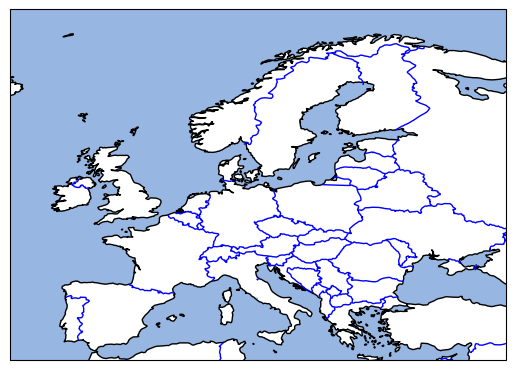

In [266]:
plt.figure()

un_admin = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m')

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(un_admin, facecolor='None', edgecolor='b')
ax.set_extent([-15, +40, 35, 72])  # roughly Europe



<div class="alert alert-success">

##### We next get the country mask for a specific country from the PARIS NetCDF file that was distributed by Wageningen University. It contains a fractional country mask for each of the European countries in the Natural Earth database.
    
    
</div    

dict_keys(['longitude', 'latitude', 'area', 'country_name', 'country_abbrev', 'country_abbrev_timezone', 'country_area', 'RUS', 'NOR', 'GRL', 'FRA', 'SWE', 'BLR', 'UKR', 'POL', 'AUT', 'HUN', 'MDA', 'ROU', 'LTU', 'LVA', 'EST', 'DEU', 'BGR', 'GRC', 'TUR', 'ALB', 'HRV', 'CHE', 'LUX', 'BEL', 'NLD', 'PRT', 'ESP', 'IRL', 'ITA', 'DNK', 'GBR', 'ISL', 'SVN', 'FIN', 'SVK', 'CZE', 'CYN', 'CYP', 'BIH', 'MKD', 'SRB', 'MNE', 'KOS'])


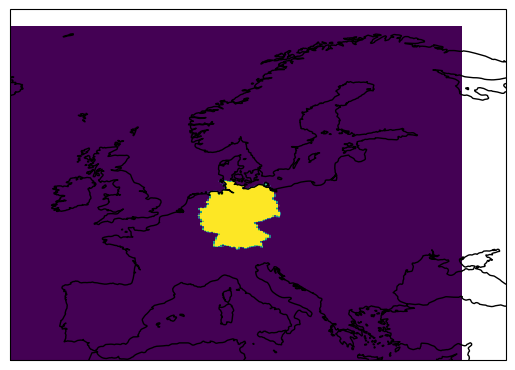

In [267]:

# Open Netcdf file and get variables. The keys define all the available country codes

with cdf.Dataset('inputs/paris_countrymask_0.2x0.1deg_2D.nc','r') as f:
    print(f.variables.keys())
    lons = f.variables['longitude'][:]
    lats = f.variables['latitude'][:]
    areaf = f.variables['area'][:] 
    file_mask = f.variables['DEU'][:]    # extract mask for 

dlon=lons[1]-lons[0]
dlat=lats[1]-lats[0]    
    
xv, yv = np.meshgrid(lons, lats)  # Make 2d arrays of the lat/lon points of the 2D grid. Note that each element [i,j] represents the lower-left corner of a gridbox

area=np.cos(np.radians(abs(yv)))*(111.1*111.1*1000*1000)*dlon*dlat

#print(area.sum(),areaf.sum())

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.pcolormesh(xv+0.5*dlon,yv+0.5*dlat,file_mask)  # pcolormesh takes center points of each box as input
ax.set_extent([-15, +40, 35, 72])  # roughly Europe


<div class="alert alert-success">

##### Now let's zoom in, plot some borders to check the mask, and then apply this country mask to the 2D array area, and print the total land area of Germany
    
</div    

The total area of this mask is 356162.3  km2


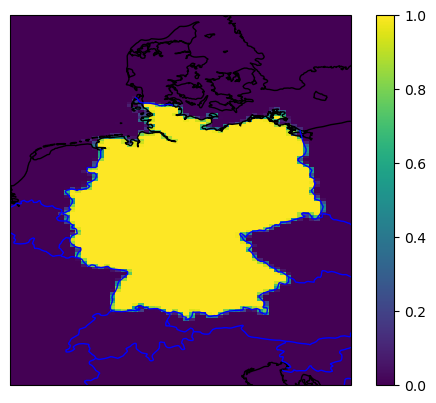

In [268]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
p=ax.pcolormesh(xv+0.5*dlon,yv+0.5*dlat,file_mask)
ax.add_feature(un_admin, facecolor='None', edgecolor='b')
plt.colorbar(p)
ax.set_extent([+4, +16, 45, 58])

print(f'The total area of this mask is {(file_mask*area).sum()/1e6:8.1f}  km2')

<div class="alert alert-success">

##### Next, let's make this mask once more but now starting from an array of lat/lon values of a (rectangular) grid and a list of shapes/geometries. This allows us to:
    
- Create various lat/lon grids and masks for them, to apply to various models and resolutions
- Use different country shapes, or other shapefiles of interest such as NUTS2 levels    
    
##### The function get_mask() below is needed for this, which takes as input a list of geometries, and a 2D grid definition    
    
</div    

In [269]:
# We will use the function below to make a binary (0/1) mask as well as a fractional mask (0.0-1.0). Note that the inputs lons/lats assume 2D arrays with lower-left corners of yur gridboxes. Irregular grids are
# allowed too, as long as they describe quadripoles (shapes with four corners)
             
def get_mask(geomlist, lonv = xv, latv = yv):  # assume lons and lats as 2D-arrays from meshgrid or so, as lower-left corners of gridboxes
    
    if lonv.any(): # grid given
        
        mask=np.zeros(lonv.shape)
        frac=np.zeros(lonv.shape)


    else: # assume global    

        mask=np.zeros((180,360,))
        frac=np.zeros((180,360,))

        lons= -180+np.arange(360)        
        lats= -90+np.arange(180)
        
        lonv, latv = np.meshgrid(lons, lats) 
        
    for j in range(latv.shape[0]):
        jj = latv[j,0]
        
        if j+1 < latv.shape[0]:
            dj = latv[j+1,0]-jj   # delta latitude from latitude array, repeat last dj value for final row from previous row
        
        jjp1 = jj+dj  # upper corner of polygon
            
        for i in range(lonv.shape[1]):
            ii = lonv[0,i]
            if i+1 < lonv.shape[1]:  
                di = lonv[0,i+1]-ii  # delta longitude from longitude array, repeat last di value for final column from last column
                
            iip1 = ii+di  # right longitude of polygon

            this_point = Point(ii+0.5*di, jj+0.5*dj)   # center point of Polygon, not needed anymore since we define binary mask based on Polygon now 

            lat_point_list = [jj,jj,jjp1,jjp1,jj]
            lon_point_list = [ii,iip1,iip1,ii,ii]

            
            this_box = Polygon(zip(lon_point_list, lat_point_list))

            for geom in geomlist:
            
                if this_box.intersects(geom):
                    frac[j,i] += (this_box.intersection(geom).area/this_box.area)  # fractional mask

                mask[j,i] = max(mask[j,i] , frac[j,i] > 0.0)  # binary mask 1/0 based on ANY overlap with geometry, be careful for double overlap, to maximize at 1.0 still...

                    
    return mask, frac

<div class="alert alert-success">

##### The cell below gets a list of MultiPoly objects, each derived from a shapefile. By using a list, we can also make a collection of countries (EU27) or add overseas areas to a definition   
    
</div    

In [282]:
# We start with some extra cartopy shapereader magic to get the shapes of all countries in a list

import cartopy.io.shapereader as shpreader
from cartopy.mpl.patch import geos_to_path
from shapely.geometry import Point, Polygon

shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()


# We next select all shapes that are associated with a specific country, in this case Germany

list_multipoly = [c.geometry for c in countries if c.attributes['SOVEREIGNT'].strip() == 'Germany']
print(list_multipoly[0].type)

MultiPolygon


The total area of this mask is 356730.4  km2


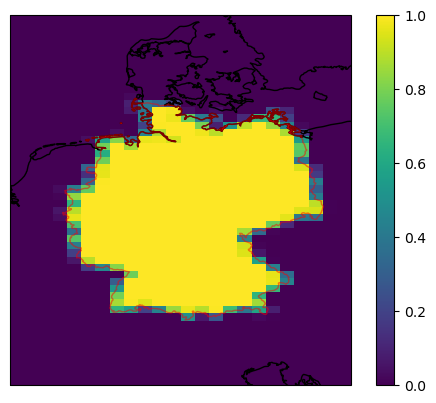

In [293]:
# Now let's create our own grid, and make the country masks next, but on a coarse fantasy grid...

dlon=0.5   # degrees
dlat=0.25 # degrees

lons = -20+np.arange(100)*dlon# from -20 to +30
lats = +30+np.arange(200)*dlat # from +30 to +80

xv, yv = np.meshgrid(lons, lats)  # Make 2d arrays of the lat/lon points of the 2D grid. Note that each element [i,j] represents the lower-left corner of a gridbox

area=np.cos(np.radians(abs(yv)))*(111.1*111.1*1000*1000)*dlon*dlat


binmask,fracmask=get_mask(list_multipoly,lonv = xv, latv = yv)  # get binary and fractional mask from shapes in Natural Earth

# and finally we plot the masked area on a map once more

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

selmask= fracmask #binmask 
p = ax.pcolormesh(xv+0.5*dlon,yv+0.5*dlat,selmask)  # provide centerpoints to polygons for pcolormesh

ax.add_geometries(list_multipoly, ccrs.PlateCarree(), edgecolor='red', facecolor='None', alpha=0.5)
plt.colorbar(p)
#ax.set_extent([-12, +4, 45, 68])
ax.set_extent([+4, +16, 45, 58])


print(f'The total area of this mask is {(selmask*area).sum()/1e6:8.1f}  km2')

<div class="alert alert-success">

##### Now let's get a flux field from a file and mask it, using the file specific lat/lon definition, and then plot it   
    
</div    

In [294]:
filename = '/project/paris/demo/inputs/paris_ctehr_perturbedflux_yr1_HGER_monmean.nc'

with cdf.Dataset(filename,'r') as f:
    # Load data from file into arrays
    lat_local = f.variables['latitude'][:]
    lon_local = f.variables['longitude'][:]
    combustion_local = f.variables['F_On-road'][:]
    ff = f.variables['flux_ff_exchange_prior'][:]

    
xv, yv = np.meshgrid(lon_local, lat_local)  # Make 2d arrays of the lat/lon points of the 2D grid. Note that each element [i,j] represents the lower-left corner of a gridbox

dlon=lon_local[1]-lon_local[0]
dlat=lat_local[1]-lat_local[0]

area=np.cos(np.radians(abs(yv)))*(111.1*111.1*1000*1000)*dlon*dlat

binmask,fracmask=get_mask(list_multipoly,lonv = xv, latv = yv)  # get binary and fractional mask from shapes in Natural Earth


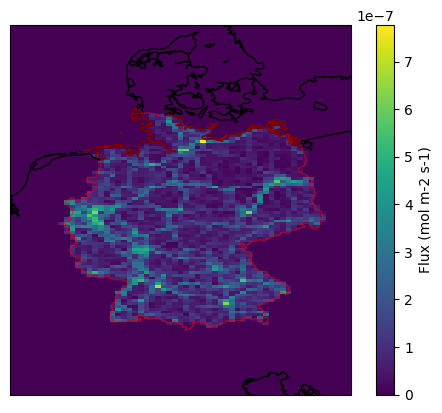

In [295]:
plotmat = combustion_local[0,:,:]

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_geometries(list_multipoly, ccrs.PlateCarree(), edgecolor='red', facecolor='None', alpha=0.5)
cs=plt.pcolormesh(xv+0.5*dlon,yv+0.5*dlat,plotmat*fracmask)
cbar = plt.colorbar()
cbar.set_label('Flux (mol m-2 s-1)')
#ax.set_extent([-12, +4, 45, 68])
ax.set_extent([+4, +16, 45, 58])
plt.show()

<div class="alert alert-success">

##### Finally, make the sum of a flux over the area of a list of countries   
    
</div    

In [297]:
# Open Netcdf file and get variables. The keys define all the available country codes

countries = ['DEU','NLD','GBR','NOR']
masks = {}
with cdf.Dataset('inputs/paris_countrymask_0.2x0.1deg_2D.nc','r') as f: 
    for ccc in countries:
        file_mask = f.variables[ccc][:]    # extract mask for 
        masks[ccc] = file_mask

for k,v in masks.items():
    print(f'Total area in country {k} = {(v*area).sum()/1e6:5.3e} km2')
    print(f'Total flux in country {k} = {(v*area*ff.mean(axis=0)).sum()*12*86400*365/1e12:4.2f} TgC/yr')
    print(f'Total flux in country {k} = {(v*area*ff.mean(axis=0)).sum()*44*86400*365/1e12:4.2f} Mton CO2/yr \n')

Total area in country DEU = 3.562e+05 km2
Total flux in country DEU = 209.27 TgC/yr
Total flux in country DEU = 767.31 Mton CO2/yr 

Total area in country NLD = 3.694e+04 km2
Total flux in country NLD = 42.12 TgC/yr
Total flux in country NLD = 154.43 Mton CO2/yr 

Total area in country GBR = 2.426e+05 km2
Total flux in country GBR = 98.74 TgC/yr
Total flux in country GBR = 362.03 Mton CO2/yr 

Total area in country NOR = 3.180e+05 km2
Total flux in country NOR = 5.26 TgC/yr
Total flux in country NOR = 19.30 Mton CO2/yr 



<div class="alert alert-success">

##### Finally, make the sum of a flux over the area of a list of countries, for both the base file and the modified flux file from our protocol   
    
</div    

In [287]:
filename = '/project/paris/demo/inputs/paris_input_monmean.nc'

with cdf.Dataset(filename,'r') as f:
    combustion_local_base = f.variables['F_On-road'][:]
    
filename = '/project/paris/demo/inputs/paris_ctehr_perturbedflux_yr1_HGER_monmean.nc'

with cdf.Dataset(filename,'r') as f:
    combustion_local = f.variables['F_On-road'][:]    

In [298]:
for k,v in masks.items():
    print(f'Total area in country {k} = {(v*area).sum()/1e6:5.3e} km2')
    print(f'Total flux in country {k} = {(v*area*combustion_local.mean(axis=0)).sum()*12*86400*365/1e12:4.2f} TgC/yr')
    print(f'Total flux in country {k} = {(v*area*combustion_local_base.mean(axis=0)).sum()*12*86400*365/1e12:4.2f} TgC/yr \n')

Total area in country DEU = 3.562e+05 km2
Total flux in country DEU = 21.50 TgC/yr
Total flux in country DEU = 39.23 TgC/yr 

Total area in country NLD = 3.694e+04 km2
Total flux in country NLD = 7.39 TgC/yr
Total flux in country NLD = 7.89 TgC/yr 

Total area in country GBR = 2.426e+05 km2
Total flux in country GBR = 31.41 TgC/yr
Total flux in country GBR = 31.41 TgC/yr 

Total area in country NOR = 3.180e+05 km2
Total flux in country NOR = 2.43 TgC/yr
Total flux in country NOR = 2.43 TgC/yr 



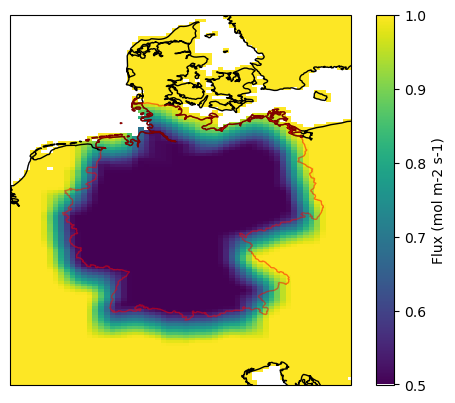

In [289]:
plotmat=(combustion_local/combustion_local_base)[0,:,:]

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_geometries(list_multipoly, ccrs.PlateCarree(), edgecolor='red', facecolor='None', alpha=0.5)
cs=plt.pcolormesh(xv+0.5*dlon,yv+0.5*dlat,plotmat)
cbar = plt.colorbar()
cbar.set_label('Flux (mol m-2 s-1)')
#ax.set_extent([-12, +4, 45, 68])
ax.set_extent([+4, +16, 45, 58])
plt.show()

<div class="alert alert-success">

##### Test cells below, do not remove
    
</div    

In [14]:
dlon=1
dlat=1

lons=-180+np.arange(360)*dlon
lats=-90+np.arange(180)*dlat

xv,yv = np.meshgrid(lons,lats)


grid=np.cos(np.radians(abs(yv)))*(111.1*111.1*1000*1000)*dlon*dlat

In [15]:
print(f'{grid.sum():5.2e}')  # in m2

5.09e+14


In [16]:
dlon=0.2
dlat=0.1

lons=-14.9+np.arange(250)*dlon
lats=33.05+np.arange(390)*dlat

xv,yv = np.meshgrid(lons,lats)

grid=np.cos(np.radians(abs(yv)))*(111.1*111.1*1000*1000)*dlon*dlat

In [17]:
print(f'{grid.sum():5.2e}')  # in m2

1.44e+13


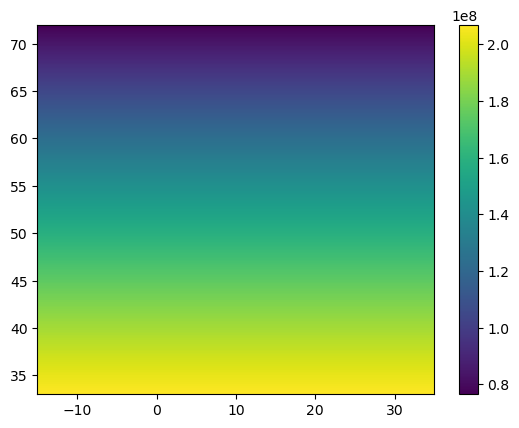

In [18]:
p= plt.pcolormesh(xv,yv,grid)
plt.colorbar(p)

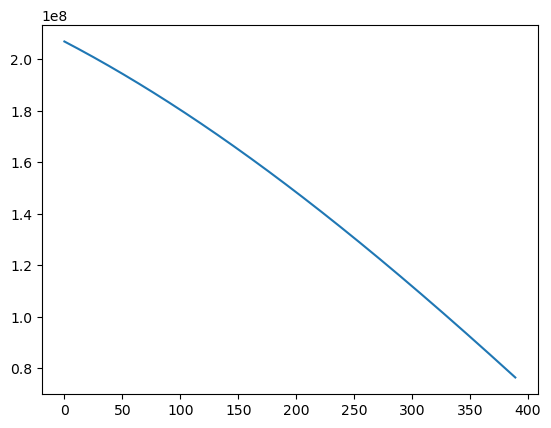

In [19]:
plt.plot(area[:,0])